# **Prédiction du logarithme du prix d'un AirBnB**

### 0.X. Import des librairies et ouverture du fichier

In [ ]:
# Import des librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import plotly.express as px
from textblob import TextBlob
import re

from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.inspection import permutation_importance

# Chargement des données
from google.colab import drive
drive.mount('/content/drive')
tr = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/airbnb_train.csv')
tr.info()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22234 entries, 0 to 22233
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      22234 non-null  int64  
 1   log_price               22234 non-null  float64
 2   property_type           22234 non-null  object 
 3   room_type               22234 non-null  object 
 4   amenities               22234 non-null  object 
 5   accommodates            22234 non-null  int64  
 6   bathrooms               22183 non-null  float64
 7   bed_type                22234 non-null  object 
 8   cancellation_policy     22234 non-null  object 
 9   cleaning_fee            22234 non-null  bool   
 10  city                    22234 non-null  object 
 11  description             22234 non-null  object 
 12  first_review   

## Partie 1 - *Exploration des données*

### 1.A. Exploration initiale



 On remarque que 17 des 28 variables sont sous forme qualitative, nous allons devoir les traiter de manière cohérente pour faciliter leur usage.

En premier lieu, nous allons voir quelles variables ont des valeurs vides.

In [ ]:
tr.isnull().sum()

,0
id,0
log_price,0
property_type,0
room_type,0
amenities,0
accommodates,0
bathrooms,51
bed_type,0
cancellation_policy,0
cleaning_fee,0


> On observe que les colonnes *host_has_profile_pic*, *host_identity_verified* et *host_since* ont le même nombre de valeurs null. Nous allons voir si cela correspond aux mêmes logements AirBnB.

In [ ]:
cols = ['host_has_profile_pic', 'host_identity_verified', 'host_since']
na_sets = [set(tr[tr[col].isna()].index) for col in cols]
meme_null = all(na_sets[0]== s for s in na_sets[1:])
print("Les colonnes ont des NaN aux mêmes lignes : ")
print(meme_null)

Les colonnes ont des NaN aux mêmes lignes : 
True


Les colonnes d'informations sur l'hôte qui sont vides le sont pour les mêmes AirBnB.

Etudions maintenant la distribution de la variable cible.

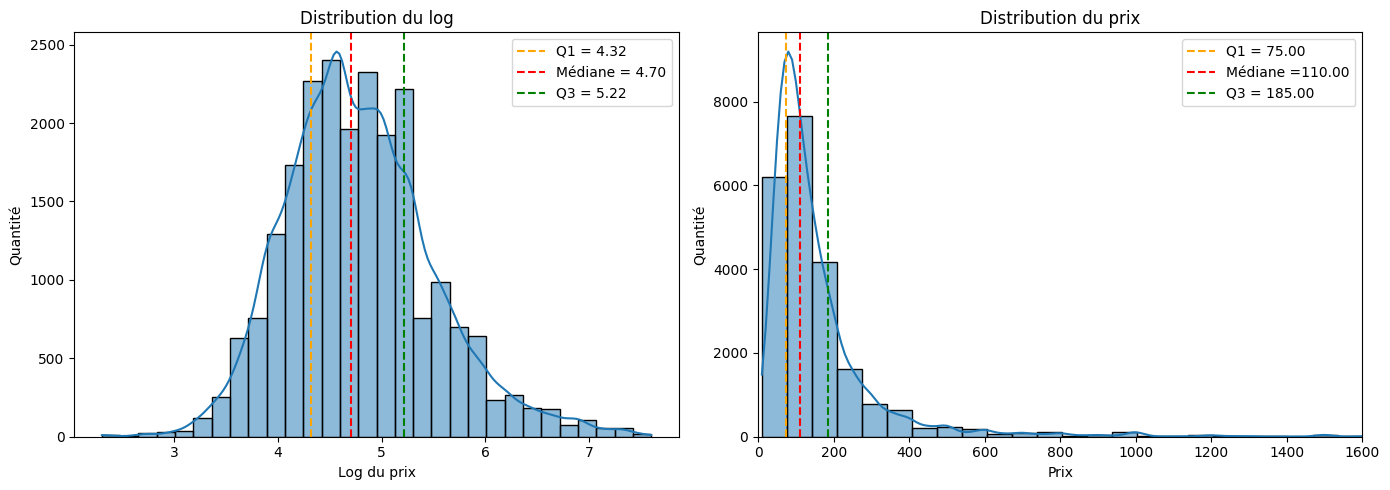

In [ ]:
# On génère le prix en monnaie
price = np.exp(tr['log_price'])

# Quartiles
q1_log = tr['log_price'].quantile(0.25)
median_log = tr['log_price'].quantile(0.5)
q3_log = tr['log_price'].quantile(0.75)

q1_price = price.quantile(0.25)
median_price = price.quantile(0.5)
q3_price = price.quantile(0.75)

# Créer des sous graphes pour comparer
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution du log
sns.histplot(tr['log_price'], bins = 30, kde = True, ax = axes[0])
axes[0].set_title('Distribution du log')
axes[0].set_xlabel('Log du prix')
axes[0].set_ylabel('Quantité')
axes[0].axvline(q1_log, color = 'orange', linestyle = 'dashed', label = f"Q1 = {q1_log:.2f}")
axes[0].axvline(median_log, color = 'red', linestyle = 'dashed', label = f"Médiane = {median_log:.2f}")
axes[0].axvline(q3_log, color = 'green', linestyle = 'dashed', label = f"Q3 = {q3_log:.2f}")
axes[0].legend()

# Distribution du prix
sns.histplot(price, bins = 30, kde = True, ax = axes[1])
axes[1].set_title('Distribution du prix')
axes[1].set_xlabel('Prix')
axes[1].set_ylabel('Quantité')
axes[1].axvline(q1_price, color = 'orange', linestyle = 'dashed', label = f"Q1 = {q1_price:.2f}")
axes[1].axvline(median_price, color = 'red', linestyle = 'dashed', label = f"Médiane ={median_price:.2f}")
axes[1].axvline(q3_price, color = 'green', linestyle = 'dashed', label = f"Q3 = {q3_price:.2f}")
axes[1].set_xlim(0, price.quantile(0.999))
axes[1].legend()
plt.tight_layout()
plt.show()

> On constate que le log permet une modélisation plus pertinente pour un algorithme de prédiction par sa forme gaussienne, à l'inverse de la distribution du prix original qui a une asymétrie très forte à droite.


### 1.B. Analyse univariée

D'abord, étudions les variables quantitatives :

In [ ]:
# Moyenne, médianne et écart type des colonnes quantitatives
stats_quant = tr.select_dtypes(include=['float64', 'int64']).drop(columns=['id', 'log_price', 'latitude', 'longitude']).agg(['mean', 'median', 'std', 'min', 'max']).transpose()
print(stats_quant)

                           mean  median        std   min    max
accommodates           3.155573     2.0   2.143870   1.0   16.0
bathrooms              1.236037     1.0   0.586246   0.0    8.0
number_of_reviews     20.670774     6.0  37.183731   0.0  505.0
review_scores_rating  94.069077    96.0   7.782235  20.0  100.0
bedrooms               1.264769     1.0   0.852819   0.0   10.0
beds                   1.711473     1.0   1.254903   0.0   18.0


Etudions aussi les variables booléennes :

In [ ]:
# Fréquences des différentes modalités pour les variables binaires
colonnes_bool = ['cleaning_fee', 'instant_bookable', 'host_has_profile_pic', 'host_identity_verified']
for col in colonnes_bool:
  print(f"\n---")
  print(tr[col].value_counts(dropna=False, normalize=True))


---
cleaning_fee
True     0.737654
False    0.262346
Name: proportion, dtype: float64

---
instant_bookable
f    0.737654
t    0.262346
Name: proportion, dtype: float64

---
host_has_profile_pic
t      0.994333
f      0.003148
NaN    0.002519
Name: proportion, dtype: float64

---
host_identity_verified
t      0.672529
f      0.324953
NaN    0.002519
Name: proportion, dtype: float64


On pourrait évaluer les zones denses en airbnb à partir des coordonnées pour voir si ça influence sur le prix
-> En gros j'ai l'intuition que les coordonnées/la ville jouent beaucoup sur le prix donc faudrait réussir à exploiter ça

Et finalement les variables qualitatives :

In [ ]:
# Sans savoir si les données sont représentables, on préfère commencer avec un affichage textuel
colonnes_quali = ['property_type', 'room_type', 'bed_type', 'city', 'neighbourhood', 'zipcode']
for col in colonnes_quali:
  print(f"\n---")
  print(tr[col].value_counts(dropna=False))


---
property_type
Apartment             14635
House                  4965
Condominium             836
Townhouse               507
Loft                    381
Other                   200
Guesthouse              156
Bed & Breakfast         130
Bungalow                 90
Villa                    54
Dorm                     43
Guest suite              39
Timeshare                29
Boat                     26
Boutique hotel           25
Camper/RV                23
Cabin                    22
In-law                   21
Hostel                   19
Tent                      6
Castle                    5
Serviced apartment        5
Vacation home             4
Chalet                    3
Hut                       3
Yurt                      2
Cave                      1
Tipi                      1
Earth House               1
Island                    1
Treehouse                 1
Name: count, dtype: int64

---
room_type
Entire home/apt    12348
Private room        9219
Shared room          6

> On remarque tout de suite que le jeu de données vient de 6 grandes villes aux Etats-Unis, avec 559 quartiers différents et 675 code postaux.

> Il y a 31 types de propriété, 3 types de chambre et 5 types de lit. Nous allons voir comment exploiter ces informations. D'abord, quelques visualisations pertinentes :

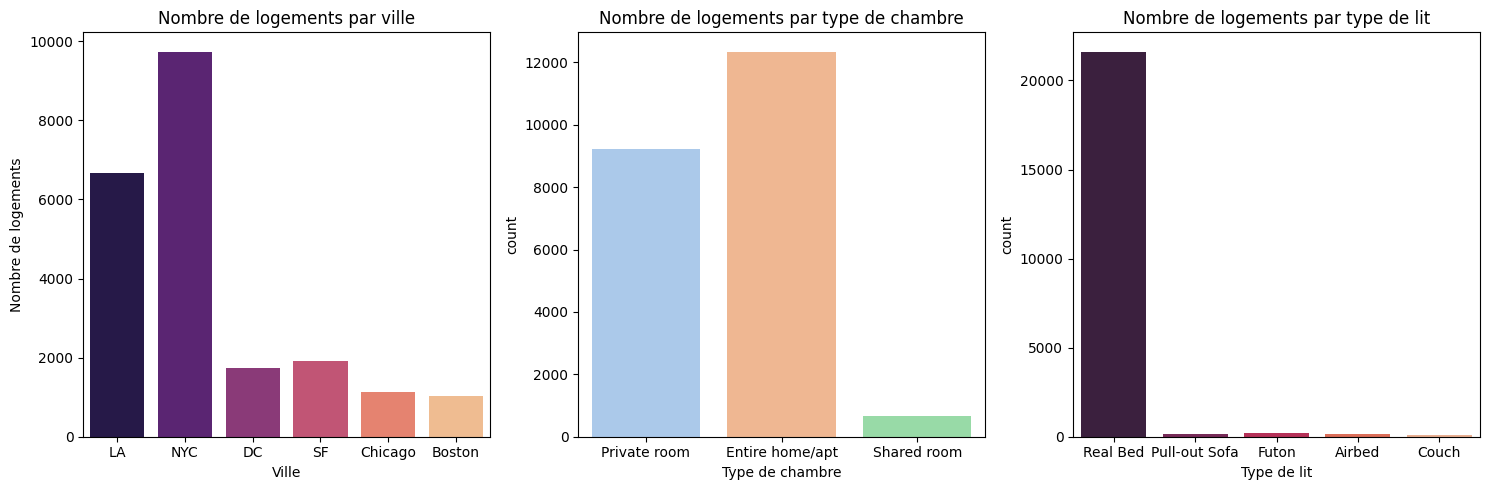

In [ ]:
# Représentation barplot des variables ville, type de chambre et type de lit
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Ville
sns.countplot(x='city', hue='city', data=tr, palette = 'magma', ax=axes[0])
axes[0].set_title('Nombre de logements par ville')
axes[0].set_xlabel('Ville')
axes[0].set_ylabel('Nombre de logements')

# Type de chambre
sns.countplot(x='room_type', hue='room_type', data=tr, palette = 'pastel', ax=axes[1])
axes[1].set_title('Nombre de logements par type de chambre')
axes[1].set_xlabel('Type de chambre')

# Type de lit
sns.countplot(x='bed_type', hue='bed_type', data=tr, palette = 'rocket', ax=axes[2])
axes[2].set_title('Nombre de logements par type de lit')
axes[2].set_xlabel('Type de lit')

plt.tight_layout()
plt.show()

### 1.C. Analyse Multivariée

Affichons maintenant une matrice de corrélation :

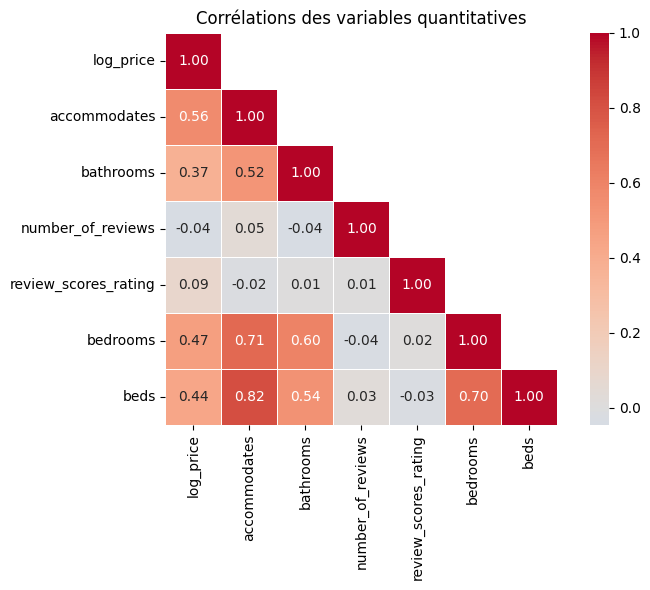

In [ ]:
# Sélection des colonnes quantitatives
corr = tr.select_dtypes(include=['float64', 'int64']).drop(columns=['id', 'latitude', 'longitude'])
corr_mat=corr.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_mat, cmap='coolwarm', mask = np.triu(np.ones_like(corr_mat, dtype=bool), k=1), center=0, square=True, linewidths=0.5, annot=True, fmt=".2f")
plt.title('Corrélations des variables quantitatives')
plt.tight_layout()
plt.show()

> Nous pouvons commenter sur plusieurs aspects. Premièrement, on observe une forte corrélation entre le log(prix) et le nombre de personnes que le logement peut accueillir. On a dans la même logique une corrélation proche de 50% avec le nombre de lits, le nombre de chambres et le nombre de salles de bain. La déduction logique est que le prix dépend principalement de la taille du logement (parmi les variables sélectionnées). Il n'y a cependant qu'une corrélation de 9% entre le log(prix) et la note moyenne donnée par les utilisateurs.

> Par ailleurs, on voit que le nombre de lits et le nombre de visiteurs sont évidemment très fortement corrélés (82%), et que de manière générale toutes les variables liées à la taille du logement sont corrélées entre elles.

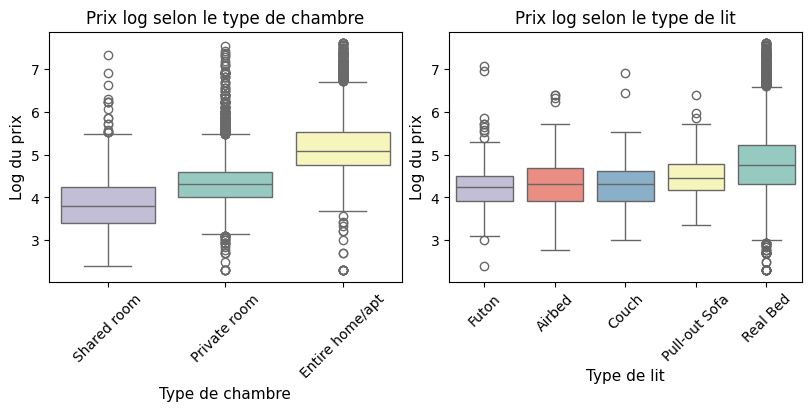

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)

sns.boxplot(ax=axes[0], x='room_type', y='log_price', hue='room_type', data=tr, palette='Set3', order=tr.groupby('room_type')['log_price'].median().sort_values().index)
axes[0].set_title('Prix log selon le type de chambre', fontsize=12)
axes[0].set_xlabel('Type de chambre', fontsize=11)
axes[0].set_ylabel('Log du prix', fontsize=11)
axes[0].tick_params(axis='x', rotation=45, labelsize=10)

sns.boxplot(ax=axes[1], x='bed_type', y='log_price', hue='bed_type', data=tr, palette='Set3', order=tr.groupby('bed_type')['log_price'].median().sort_values().index)
axes[1].set_title('Prix log selon le type de lit', fontsize=12)
axes[1].set_xlabel('Type de lit', fontsize=11)
axes[1].set_ylabel('Log du prix', fontsize=11)
axes[1].tick_params(axis='x', rotation=45, labelsize=10)

plt.show()

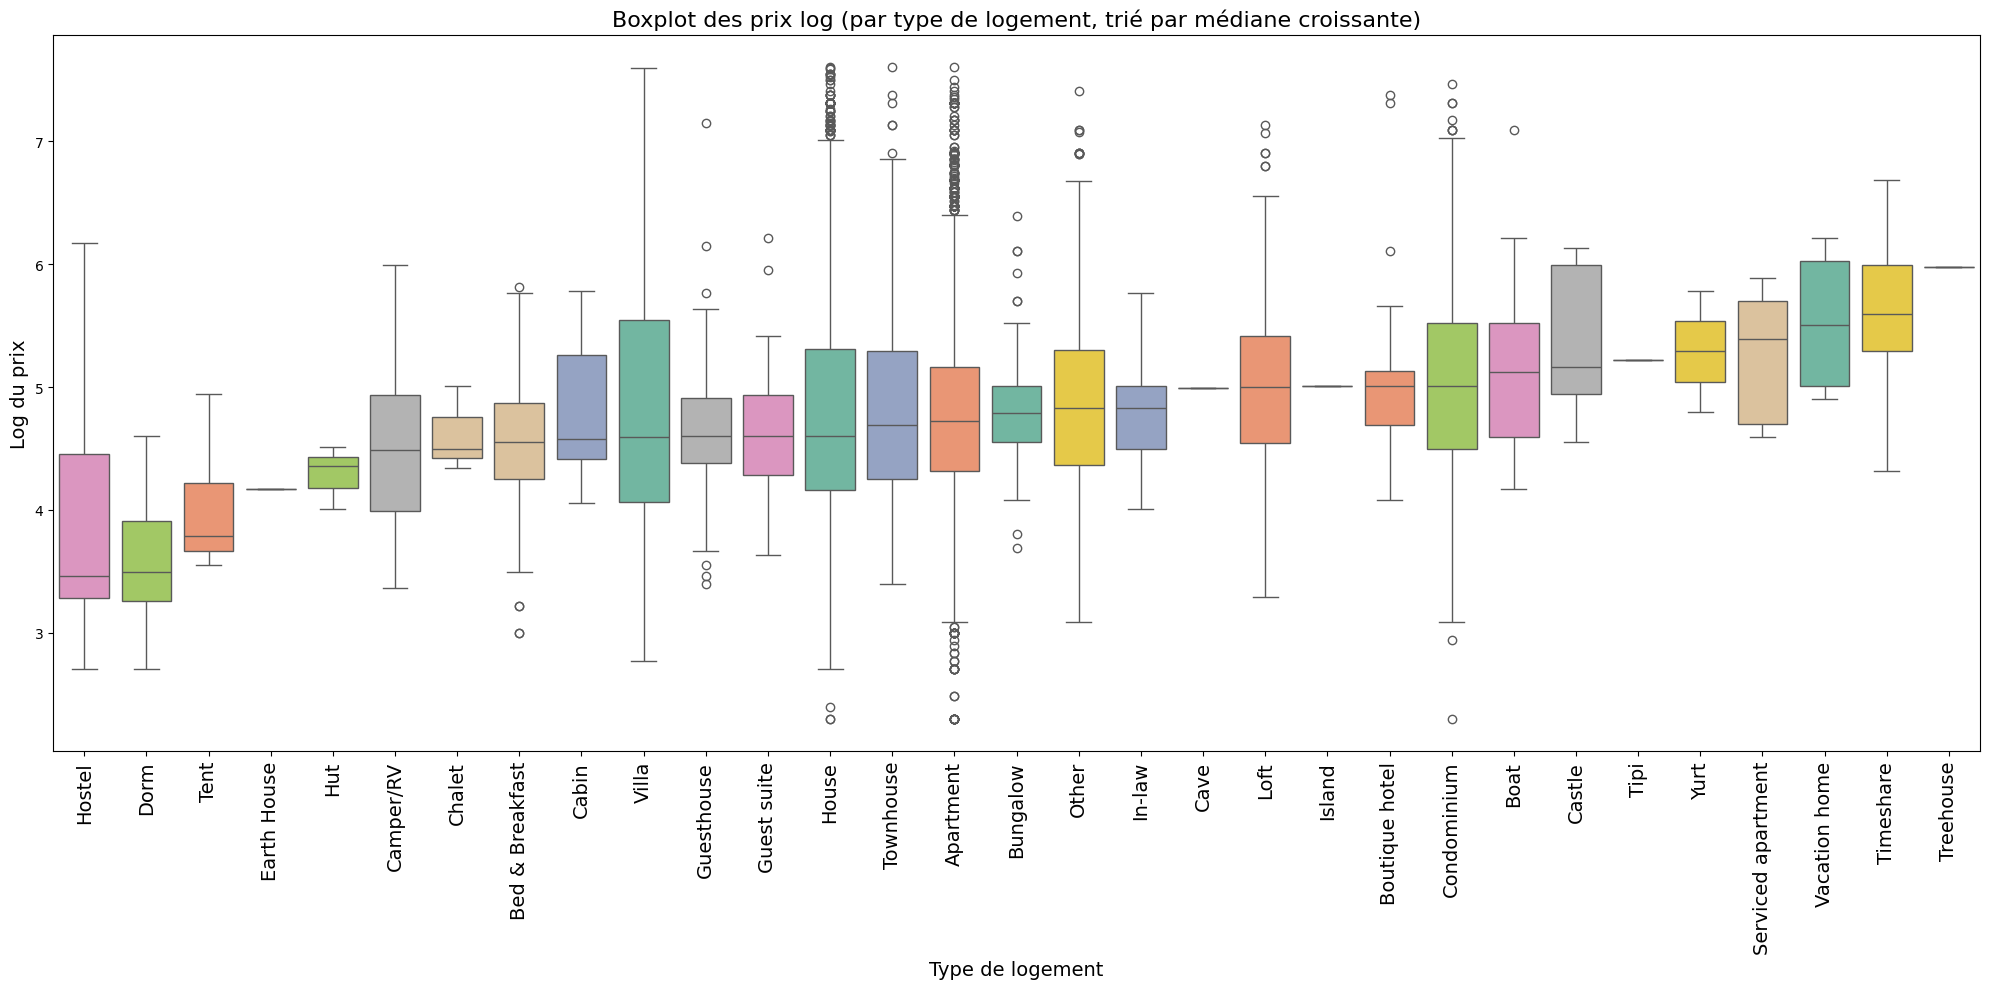

In [ ]:
plt.figure(figsize=(20, 10))
sns.boxplot(x='property_type', hue='property_type', y='log_price', data=tr, palette= 'Set2', order= tr.groupby('property_type')['log_price'].median().sort_values(ascending=True).index)

plt.xticks(rotation=90, fontsize=14)
plt.title('Boxplot des prix log (par type de logement, trié par médiane croissante)', fontsize=16)
plt.xlabel('Type de logement', fontsize=14)
plt.ylabel('Log du prix', fontsize=14)

plt.tight_layout()
plt.show()

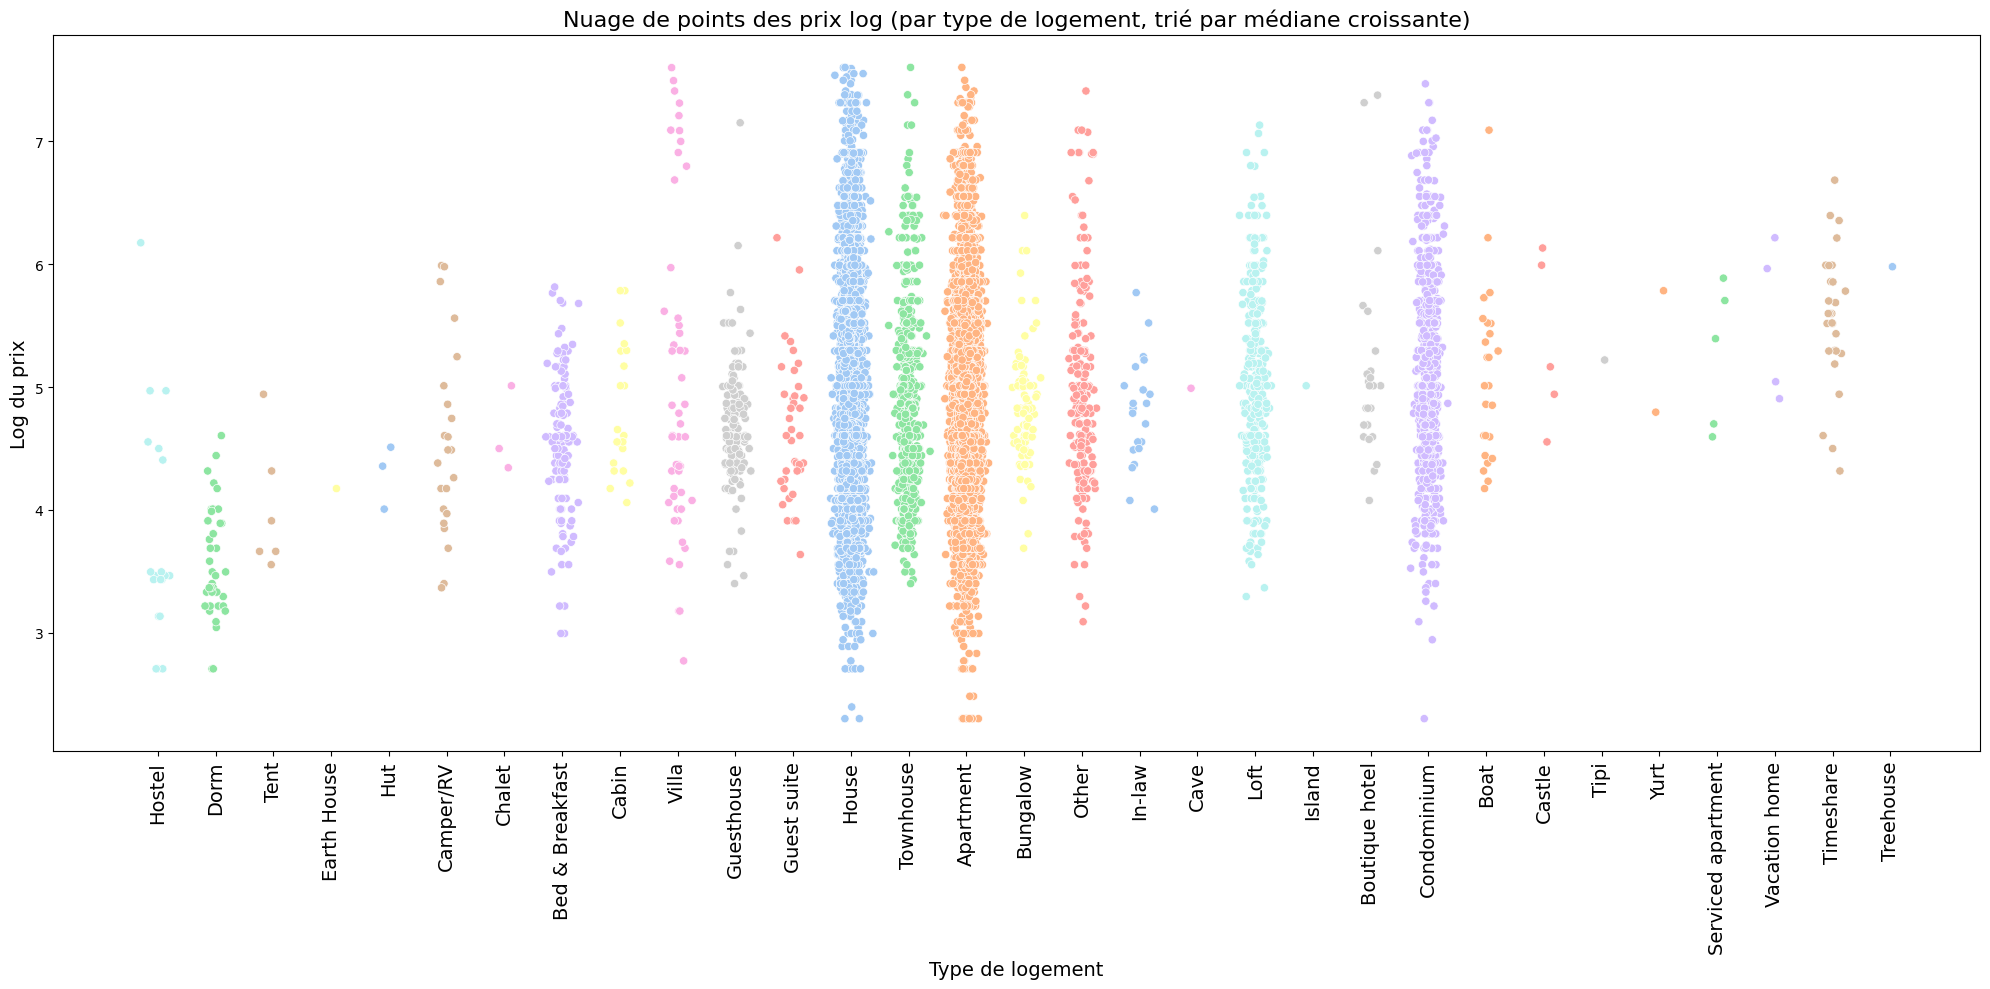

In [ ]:
ordered_types = tr.groupby('property_type')['log_price'].median().sort_values(ascending=True).index
plt.figure(figsize=(20, 10))
tr['x_jittered'] = tr['property_type'].apply(lambda x: np.random.normal(loc=np.where(ordered_types == x)[0][0], scale=0.1))
sns.scatterplot(x='x_jittered', y='log_price', data=tr, hue='property_type', palette='pastel', legend=False)

plt.xticks(ticks=np.arange(len(ordered_types)), labels=ordered_types, rotation=90, fontsize=14)
plt.title('Nuage de points des prix log (par type de logement, trié par médiane croissante)', fontsize=16)
plt.xlabel('Type de logement', fontsize=14)
plt.ylabel('Log du prix', fontsize=14)
tr = tr.drop(columns=['x_jittered'])
plt.tight_layout()
plt.show()

> Les deux affichages permettent de visualiser de deux façons différentes la distribution des prix à travers les types de logement. Nous les avons triés par médiane pour faciliter la lecture. Du premier coup d'oeil, on voit par exemple que les auberges de jeunesse et dortoirs sont les types de logement les moins chers sur notre dataset. Le boxplot nous aide à voir la médiane et les quartiles, et le scatterplot permet de visualiser l'étendue des données au sein d'une unique catégorie de logement.

Affichons maintenant une carte des USA qui représente la densité des AirBnB

In [ ]:
import folium
from folium.plugins import HeatMap

# Initialiser la carte centrée sur les USA
m = folium.Map(location=[37, -95], zoom_start=5)

# Extraire les données nécessaires pour la heatmap (latitude, longitude, prix)
HeatMap([[row['latitude'], row['longitude'], row['log_price']] for index, row in tr.iterrows()], min_opacity=0.2, radius=15).add_to(m)

m

## Partie 2 - *Prétraitement des données*

### 2.A. Nettoyage Initial

**Colonnes à supprimer :**

* name redondant avec description

* zipcode déjà capturé par city + latitude/longitude

In [ ]:
tr = tr.drop(columns=['name','zipcode', 'neighbourhood'])

**Correction des booléens :**

In [ ]:
bool_mapping = {'t': 1, 'f': 0, True: 1, False: 0}
for col in ['cleaning_fee', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable']:
  tr[col] = tr[col].fillna('f').map(bool_mapping).astype('int8')

### 2.B. Traitement des Valeurs Manquantes

In [ ]:
# 1. Colonnes booléennes
bool_cols = ['cleaning_fee', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable']
for col in bool_cols:
    # Créer un indicateur de valeur manquante
    tr[f'{col}_missing'] = tr[col].isna().astype('int8')
    # Imputation avec le mode
    mode_val = tr[col].mode()[0]
    tr[col] = tr[col].fillna(mode_val).replace({'t': 1, 'f': 0, True: 1, False: 0}).astype('int8')

In [ ]:
# 2. Colonnes Numériques
num_cols = ['bathrooms', 'bedrooms', 'beds', 'review_scores_rating', 'host_response_rate']
for col in num_cols:
    if col == 'host_response_rate':
        tr[col] = tr[col].str.rstrip('%').astype(float)
    tr[f'{col}_missing'] = tr[col].isna().astype('int8')
    tr[col] = tr[col].fillna(tr[col].median())

In [ ]:
# 3. Colonnes Temporelles
date_cols = ['host_since', 'first_review', 'last_review']
for col in date_cols:
        # Conversion en datetime
        tr[col] = pd.to_datetime(tr[col], errors='coerce')

        # Création de la feature dérivée
        tr[f'days_since_{col}'] = (pd.to_datetime('today') - tr[col]).dt.days

        # Imputation des valeurs manquantes
        default_days = 365 * 10  # 10 ans comme valeur par défaut
        tr[f'days_since_{col}'] = tr[f'days_since_{col}'].fillna(default_days)

        # Suppression de la colonne originale
        tr = tr.drop(columns=[col])
tr = tr.rename(columns={'days_since_host_since': 'days_since_host'})


In [ ]:
print(tr.columns.tolist())

['id', 'log_price', 'property_type', 'room_type', 'amenities', 'accommodates', 'bathrooms', 'bed_type', 'cancellation_policy', 'cleaning_fee', 'city', 'description', 'host_has_profile_pic', 'host_identity_verified', 'host_response_rate', 'instant_bookable', 'latitude', 'longitude', 'number_of_reviews', 'review_scores_rating', 'bedrooms', 'beds', 'cleaning_fee_missing', 'host_has_profile_pic_missing', 'host_identity_verified_missing', 'instant_bookable_missing', 'bathrooms_missing', 'bedrooms_missing', 'beds_missing', 'review_scores_rating_missing', 'host_response_rate_missing', 'days_since_host', 'days_since_first_review', 'days_since_last_review']


In [ ]:
# 4. Colonnes Textuelles
text_cols = ['description', 'amenities']
tr['n_amenities'] = tr['amenities'].apply(lambda x: len(str(x).split(',')) if pd.notna(x) else 0)
tr['amenities_missing'] = tr['amenities'].isna().astype('int8')

# Pour 'description'
tr['desc_length'] = tr['description'].str.len().fillna(0).astype('int16')
tr['desc_missing'] = tr['description'].isna().astype('int8')

In [ ]:
# 5. Colonnes Catégorielles
cat_cols = ['property_type', 'room_type', 'bed_type', 'cancellation_policy', 'city']
for col in cat_cols:
    # Ajouter une catégorie 'missing'
    tr[col] = tr[col].astype('category').cat.add_categories(['missing']).fillna('missing')
    # Optimisation mémoire
    tr[col] = tr[col].cat.remove_unused_categories()

In [ ]:
# 7. Vérification finale
print("Valeurs manquantes restantes :")
print(tr.isna().sum().sort_values(ascending=False))

Valeurs manquantes restantes :
id                                0
log_price                         0
property_type                     0
room_type                         0
amenities                         0
accommodates                      0
bathrooms                         0
bed_type                          0
cancellation_policy               0
cleaning_fee                      0
city                              0
description                       0
host_has_profile_pic              0
host_identity_verified            0
host_response_rate                0
instant_bookable                  0
latitude                          0
longitude                         0
number_of_reviews                 0
review_scores_rating              0
bedrooms                          0
beds                              0
cleaning_fee_missing              0
host_has_profile_pic_missing      0
host_identity_verified_missing    0
instant_bookable_missing          0
bathrooms_missing                

In [ ]:
tr.head(10)

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,beds_missing,review_scores_rating_missing,host_response_rate_missing,days_since_host,days_since_first_review,days_since_last_review,n_amenities,amenities_missing,desc_length,desc_missing
0,5708593,4.317488,House,Private room,"{TV,""Wireless Internet"",Kitchen,""Free parking ...",3,1.0,Real Bed,flexible,0,...,0,1,1,3443.0,3650.0,3650.0,15,0,669,0
1,14483613,4.007333,House,Private room,"{""Wireless Internet"",""Air conditioning"",Kitche...",4,2.0,Real Bed,strict,0,...,0,0,0,3115.0,2931.0,2798.0,25,0,1000,0
2,10412649,7.090077,Apartment,Entire home/apt,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",6,2.0,Real Bed,flexible,0,...,0,1,1,3078.0,3650.0,3650.0,20,0,494,0
3,17954362,3.555348,House,Private room,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1,1.0,Real Bed,flexible,1,...,0,0,0,4668.0,3143.0,2786.0,30,0,1000,0
4,9969781,5.480639,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,moderate,1,...,0,0,0,4313.0,3155.0,2818.0,24,0,1000,0
5,13113872,6.214608,Apartment,Private room,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,1,...,0,1,1,4561.0,3650.0,3650.0,11,0,603,0
6,12032987,4.499810,Townhouse,Private room,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",2,1.0,Real Bed,strict,1,...,0,0,1,3650.0,2899.0,2793.0,29,0,1000,0
7,12112830,4.394449,Guest suite,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",3,1.0,Pull-out Sofa,moderate,0,...,0,0,0,4505.0,4435.0,2790.0,32,0,1000,0
8,16738953,4.025352,Apartment,Private room,"{Internet,""Wireless Internet"",Kitchen,""Pets al...",3,1.0,Real Bed,moderate,1,...,0,1,0,3546.0,3650.0,3650.0,11,0,1000,0
9,94477,5.521461,Apartment,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",4,1.0,Real Bed,moderate,1,...,0,0,0,3805.0,3720.0,2799.0,18,0,707,0


In [ ]:
tout_amenities = set()
for amenities_str in tr['amenities'].dropna():
  amenities = amenities_str.split(',')
  for amenity in amenities:
      amenity = amenity.strip()
      if amenity:
        tout_amenities.add(amenity)

print(list(tout_amenities))


['"Smart lock"}', '"BBQ grill"', '"Doorman Entry"}', '"Path to entrance lit at night"', '"Long term stays allowed"}', 'Cat(s)', 'Pool', '"Wheelchair accessible"', 'TV}', '"Accessible-height bed"}', 'Heating}', '"Fire extinguisher"}', '"Pets allowed"}', '{"translation missing: en.hosting_amenity_49"}', '{"Self Check-In"', '"Smart lock"', 'Heating', '{"Suitable for events"', '"Free parking on premises"}', '"24-hour check-in"', '"Children’s books and toys"', '{"Pets allowed"', '"Laptop friendly workspace"}', '"Other pet(s)"', '"Wide clearance to shower & toilet"}', '"Wide doorway"', '"Free parking on street"', 'Lockbox', 'Bathtub', '"Coffee maker"}', '"Patio or balcony"', 'Waterfront', '"Baby bath"', '"Pocket wifi"}', '"Host greets you"', '"Wide entryway"}', '"24-hour check-in"}', 'Stove', 'Dishwasher', '"Fireplace guards"', '"Changing table"', '{Stove', '"Hair dryer"', 'Crib', '{Essentials', '"Private living room"', 'Microwave}', '"EV charger"', '"Cleaning before checkout"', '"Room-darke

### 2.C. Feature Engineering

1. Features géographiques

In [ ]:
# Clustering géographique
coords = tr[['latitude', 'longitude']].dropna()
kmeans = KMeans(n_clusters=10, random_state=42).fit(coords)
tr['geo_cluster'] = kmeans.predict(tr[['latitude', 'longitude']])

# Distance au centre-ville
def distance_to_center(lat, lon, city):
    centers = {
        'NYC': (40.782222, -73.965278),
        'LA': (34.0522, -118.2437),
        'DC': (38.89511, -77.03637),
        'SF': (37.78799, -122.40744),
        'Chicago': (41.88373, -87.63240),
        'Boston': (42.35543, -71.06051)
    }
    if city in centers:
        center_lat, center_lon = centers[city]
        return ((lat - center_lat)**2 + (lon - center_lon)**2)**0.5
    return np.nan

tr['city_center_distance'] = tr.apply(lambda x: distance_to_center(x['latitude'], x['longitude'], x['city']), axis=1)

2. Features textuelles avancées

In [ ]:
# Nettoyage approfondi
tr['description'] = tr['description'].fillna('').str.replace(r'[^a-zA-Z\s]', '', regex=True).str.lower()

# Features NLP
desc_blobs = tr['description'].apply(TextBlob)
tr['desc_sentiment'] = desc_blobs.apply(lambda x: x.sentiment.polarity)
tr['desc_subjectivity'] = desc_blobs.apply(lambda x: x.sentiment.subjectivity)
tr['desc_word_count'] = tr['description'].str.count(r'\w+')
tr['desc_has_wifi'] = tr['description'].str.contains(r'\bwifi\b|\binternet\b', case=False).astype(int)
mot_cles = ['doorman', 'garage', 'gym', 'pool', 'jacuzzi']
for mot in mot_cles:
    tr[f'desc_has_{mot}'] = tr['description'].str.contains(mot, case=False).astype(int)
# Extraire les équipements premium
premium_amenities = ['jacuzzi', 'pool', 'gym', 'sauna', 'doorman', 'garage']
for am in premium_amenities:
    tr[f'has_{am}'] = tr['amenities'].str.contains(am, case=False).astype(int)

3. Interactions entre features

In [ ]:
# Score pondéré
tr['weighted_review_score'] = tr['review_scores_rating'] * np.log1p(tr['number_of_reviews'])

# Indicateur de complétude du profil
tr['complete_profile'] = (
    tr['host_has_profile_pic'] *
    tr['host_identity_verified'] *
    (tr['host_response_rate'] > 80)
).astype(int)

4. Features catégorielles enrichies

In [ ]:
# Regroupement des catégories rares
def group_property_type(property_type):
    if property_type in ['Apartment', 'House', 'Condominium', 'Townhouse', 'Loft']:
        return property_type
    elif property_type in ['Guesthouse', 'Bed & Breakfast', 'Bungalow', 'Villa', 'Guest suite', 'In-law', 'Cabin', 'Chalet']:
        return 'Classic'
    elif property_type in ['Camper/RV', 'Tent', 'Dorm', 'Hostel']:
        return 'Shared'
    elif property_type in ['Yurt', 'Tipi', 'Hut', 'Cave', 'Earth House', 'Treehouse', 'Island']:
        return 'Exotic'
    elif property_type in ['Boutique hotel', 'Serviced apartment', 'Castle', 'Boat', 'Timeshare', 'Vacation home']:
        return 'Serviced'
    else:
        return 'Other'

tr['property_type_grouped'] = tr['property_type'].apply(group_property_type)

tr = pd.get_dummies(tr, columns=['property_type_grouped', 'room_type', 'bed_type'], dtype=int)

5. Validation des features

In [ ]:
# Corrélation avec la target
numerical_features = tr.select_dtypes(include=['number'])

correlations = numerical_features.corr()['log_price'].sort_values(ascending=False)
print(correlations.head(10), '\n')

X = tr.select_dtypes(include=['number']).drop(columns=['log_price', 'id'])
y = tr['log_price']

# On utilise un RandomForest pour vérifier l'importance de chaque features
model = RandomForestRegressor(random_state=42)
model.fit(X, y)

feature_importances = pd.Series(model.feature_importances_, index=X.columns)
print(feature_importances.nlargest(10))

log_price                    1.000000
room_type_Entire home/apt    0.597797
accommodates                 0.564874
bedrooms                     0.472728
beds                         0.435068
bathrooms                    0.368856
n_amenities                  0.198436
has_gym                      0.119243
has_doorman                  0.118882
cleaning_fee                 0.115116
Name: log_price, dtype: float64 

room_type_Entire home/apt    0.356949
bathrooms                    0.121597
city_center_distance         0.071780
longitude                    0.064228
latitude                     0.048067
accommodates                 0.033553
days_since_host              0.026481
desc_sentiment               0.025155
desc_subjectivity            0.023023
n_amenities                  0.022578
dtype: float64


### 2.D Fonction unique *pretraitement()*

On crée une méthode qu'on appellera au moment du test final

In [ ]:
def pretraitement(tr):

    tr.columns.values[0] = "id"
  # Colonnes à supprimer
    tr = tr.drop(columns=['name','zipcode', 'neighbourhood'])
  # Correction des booléens
    bool_mapping = {'t': 1, 'f': 0, True: 1, False: 0}
    for col in ['cleaning_fee', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable']:
      tr[col] = tr[col].fillna('f').map(bool_mapping).astype('int8')
  # 1. Colonnes booléennes
    bool_cols = ['cleaning_fee', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable']
    for col in bool_cols:
    # Créer un indicateur de valeur manquante
      tr[f'{col}_missing'] = tr[col].isna().astype('int8')
    # Imputation avec le mode
      mode_val = tr[col].mode()[0]
      tr[col] = tr[col].fillna(mode_val).replace({'t': 1, 'f': 0, True: 1, False: 0}).astype('int8')
    # 2. Colonnes Numériques
    num_cols = ['bathrooms', 'bedrooms', 'beds', 'review_scores_rating', 'host_response_rate']
    for col in num_cols:
      if col == 'host_response_rate':
        tr[col] = tr[col].str.rstrip('%').astype(float)
      tr[f'{col}_missing'] = tr[col].isna().astype('int8')
      tr[col] = tr[col].fillna(tr[col].median())
    # 3. Colonnes Temporelles
    date_cols = ['host_since', 'first_review', 'last_review']
    for col in date_cols:
        # Conversion en datetime
      tr[col] = pd.to_datetime(tr[col], errors='coerce')

        # Création de la feature dérivée
      tr[f'days_since_{col}'] = (pd.to_datetime('today') - tr[col]).dt.days

        # Imputation des valeurs manquantes
      default_days = 365 * 10  # 10 ans comme valeur par défaut
      tr[f'days_since_{col}'] = tr[f'days_since_{col}'].fillna(default_days)

        # Suppression de la colonne originale
      tr = tr.drop(columns=[col])
    tr = tr.rename(columns={'days_since_host_since': 'days_since_host'})
# 4. Colonnes Textuelles
    text_cols = ['description', 'amenities']
    tr['n_amenities'] = tr['amenities'].apply(lambda x: len(str(x).split(',')) if pd.notna(x) else 0)
    tr['amenities_missing'] = tr['amenities'].isna().astype('int8')

# Pour 'description'
    tr['desc_length'] = tr['description'].str.len().fillna(0).astype('int16')
    tr['desc_missing'] = tr['description'].isna().astype('int8')
# 5. Colonnes Catégorielles
    cat_cols = ['property_type', 'room_type', 'bed_type', 'cancellation_policy', 'city']
    for col in cat_cols:
    # Ajouter une catégorie 'missing'
      tr[col] = tr[col].astype('category').cat.add_categories(['missing']).fillna('missing')
    # Optimisation mémoire
      tr[col] = tr[col].cat.remove_unused_categories()
# Clustering géographique
    coords = tr[['latitude', 'longitude']].dropna()
    kmeans = KMeans(n_clusters=10, random_state=42).fit(coords)
    tr['geo_cluster'] = kmeans.predict(tr[['latitude', 'longitude']])

# Distance au centre-ville (exemple pour NYC)
    def distance_to_center(lat, lon, city):
        centers = {
            'NYC': (40.782222, -73.965278),
            'LA': (34.0522, -118.2437),
            'DC': (38.89511, -77.03637),
            'SF': (37.78799, -122.40744),
            'Chicago': (41.88373, -87.63240),
            'Boston': (42.35543, -71.06051)
        }
        if city in centers:
            center_lat, center_lon = centers[city]
            return ((lat - center_lat)**2 + (lon - center_lon)**2)**0.5
        return np.nan

    tr['city_center_distance'] = tr.apply(lambda x: distance_to_center(x['latitude'], x['longitude'], x['city']), axis=1)
    # Nettoyage approfondi
    tr['description'] = tr['description'].fillna('').str.replace(r'[^a-zA-Z\s]', '', regex=True).str.lower()

    # Features NLP
    desc_blobs = tr['description'].apply(TextBlob)
    tr['desc_sentiment'] = desc_blobs.apply(lambda x: x.sentiment.polarity)
    tr['desc_subjectivity'] = desc_blobs.apply(lambda x: x.sentiment.subjectivity)
    tr['desc_word_count'] = tr['description'].str.count(r'\w+')
    tr['desc_has_wifi'] = tr['description'].str.contains(r'\bwifi\b|\binternet\b', case=False).astype(int)
    # Vérification dans la description pour les termes supplémentaires
    extra_terms = ['doorman', 'garage', 'gym', 'pool', 'jacuzzi']
    for term in extra_terms:
        tr[f'desc_has_{term}'] = tr['description'].str.contains(term, case=False).astype(int)
    # Extraire les équipements premium
    premium_amenities = ['jacuzzi', 'pool', 'gym', 'sauna', 'doorman', 'garage']
    for am in premium_amenities:
        tr[f'has_{am}'] = tr['amenities'].str.contains(am, case=False).astype(int)
        # Score pondéré
    tr['weighted_review_score'] = tr['review_scores_rating'] * np.log1p(tr['number_of_reviews'])

    # Indicateur de complétude du profil
    tr['complete_profile'] = (
        tr['host_has_profile_pic'] *
        tr['host_identity_verified'] *
        (tr['host_response_rate'] > 80)
    ).astype(int)
    # Regroupement des catégories rares
    def group_property_type(property_type):
        if property_type in ['Apartment', 'House', 'Condominium', 'Townhouse', 'Loft']:
            return property_type
        elif property_type in ['Guesthouse', 'Bed & Breakfast', 'Bungalow', 'Villa', 'Guest suite', 'In-law', 'Cabin', 'Chalet']:
            return 'Classic'
        elif property_type in ['Camper/RV', 'Tent', 'Dorm', 'Hostel']:
            return 'Shared'
        elif property_type in ['Yurt', 'Tipi', 'Hut', 'Cave', 'Earth House', 'Treehouse', 'Island']:
            return 'Exotic'
        elif property_type in ['Boutique hotel', 'Serviced apartment', 'Castle', 'Boat', 'Timeshare', 'Vacation home']:
            return 'Serviced'
        else:
            return 'Other'

    tr['property_type_grouped'] = tr['property_type'].apply(group_property_type)

    tr = pd.get_dummies(tr, columns=['property_type_grouped', 'room_type', 'bed_type'], dtype=int)
    return tr

Verification finale du DataFrame

In [ ]:
tr.head(3)

,id,log_price,property_type,amenities,accommodates,bathrooms,cancellation_policy,cleaning_fee,city,description,...,property_type_grouped_Shared,property_type_grouped_Townhouse,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed
0,5708593,4.317488,House,"{TV,""Wireless Internet"",Kitchen,""Free parking ...",3,1.0,flexible,0,LA,large bright airy room with balconies and jac...,...,0,0,0,1,0,0,0,0,0,1
1,14483613,4.007333,House,"{""Wireless Internet"",""Air conditioning"",Kitche...",4,2.0,strict,0,NYC,private room for rent in a six bedroom apt wit...,...,0,0,0,1,0,0,0,0,0,1
2,10412649,7.090077,Apartment,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",6,2.0,flexible,0,DC,th st corridor brba condo secure boutique buil...,...,0,0,1,0,0,0,0,0,0,1


## Partie 3 : *Sélection de modèles*

In [ ]:
# Sélection des features les plus importantes
X_feature = tr[feature_importances.nlargest(50).index.tolist()]

y_label = tr['log_price']
X_train, X_test, y_train, y_test = train_test_split(X_feature, y_label, test_size=0.2, random_state=42)

In [ ]:
# HistGradientBoostingRegressor est le modèle le plus performant
gbr = HistGradientBoostingRegressor(learning_rate=0.05, max_iter=550, max_depth=8, random_state=42)

# Entraînement du modèle avec X_train et y_train
gbr.fit(X_train, y_train)

# Prédictions sur X_test
y_pred = gbr.predict(X_test)

# Calcul de l'erreur quadratique moyenne entre y_test et y_pred
mse = mean_squared_error(y_test, y_pred)
# Calcul du coefficient de détermination
r2 = r2_score(y_test, y_pred)

# Affichage des résultats
print(f" MSE : {mse:.5f}")
print(f" R² : {r2:.5%}")

 MSE : 0.15959
 R² : 68.84730%


In [ ]:
# Calcul de l'importance des caractéristiques par permutation
result = permutation_importance(gbr, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Obtention des indices pour trier les caractéristiques par ordre d'importance
sorted_idx = result.importances_mean.argsort()

features = X_test.columns.tolist()
importances_df = pd.DataFrame({
    'Feature': features,
    'Importance': result.importances_mean
})

# Tri décroissant
importances_df = importances_df.sort_values(by='Importance', ascending=False)

print("importance des features\n")
print(importances_df)

importance des features

                              Feature  Importance
0           room_type_Entire home/apt    0.430822
5                        accommodates    0.110143
2                city_center_distance    0.099313
3                           longitude    0.074810
1                           bathrooms    0.050199
4                            latitude    0.041723
14                        geo_cluster    0.023185
10                           bedrooms    0.022485
20             room_type_Private room    0.021299
13            days_since_first_review    0.011343
17               review_scores_rating    0.009924
12             days_since_last_review    0.009223
9                         n_amenities    0.007047
26    property_type_grouped_Apartment    0.006103
22         host_response_rate_missing    0.004973
15              weighted_review_score    0.003522
18                  number_of_reviews    0.003340
6                     days_since_host    0.002542
24              room_type

In [ ]:
from sklearn.model_selection import KFold

# Initialisation de KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Boucle sur les différents folds
for train_index, test_index in kf.split(X_feature):
    # Extraction des données d'entraînement et de test pour le fold courant
    X_train, X_test = X_feature.iloc[train_index], X_feature.iloc[test_index]
    y_train, y_test = y_label.iloc[train_index], y_label.iloc[test_index]

    # Initialisation du modèle HistGradientBoostingRegressor
    gbr = HistGradientBoostingRegressor(learning_rate=0.1, max_iter=600, max_depth=7, random_state=42)

    # Entraînement du modèle sur les données d'entraînement
    gbr.fit(X_train, y_train)

    # Prédiction sur les données de test
    y_pred = gbr.predict(X_test)

    # Calcul des métriques de performance
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"MSE: {mse:.2f}, R^2: {r2:.2%}")


MSE: 0.16, R^2: 68.88%
MSE: 0.16, R^2: 68.67%
MSE: 0.15, R^2: 70.80%
MSE: 0.14, R^2: 72.09%
MSE: 0.16, R^2: 68.84%


In [ ]:
# Recherche d'hyperparamètres
from sklearn.model_selection import GridSearchCV
param_grid = { # Définit les hyperparamètres à optimiser
    'learning_rate': [0.01, 0.05, 0.1],
    'max_iter': [550, 600, 650],
    'max_depth': [6, 7, 8]
}
gbr = HistGradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Configure la recherche : modèle, grille d'hyperparamètres, validation croisée (5 folds), métrique d'évaluation (MSE négative), utilisation de tous les cœurs du processeur


grid_search.fit(X_train, y_train)
print("Meilleurs Hyperparametres:", grid_search.best_params_)
# Récupère le meilleur modèle
best_gbr = grid_search.best_estimator_

# Prédictions sur les données de test
y_pred = best_gbr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.4f}, R^2: {r2:.4%}")

Meilleurs Hyperparametres: {'learning_rate': 0.05, 'max_depth': 8, 'max_iter': 550}
MSE: 0.1619, R^2: 68.9925%


Vérifions si notre modèle overfit. Nous effectuons le test suivant :

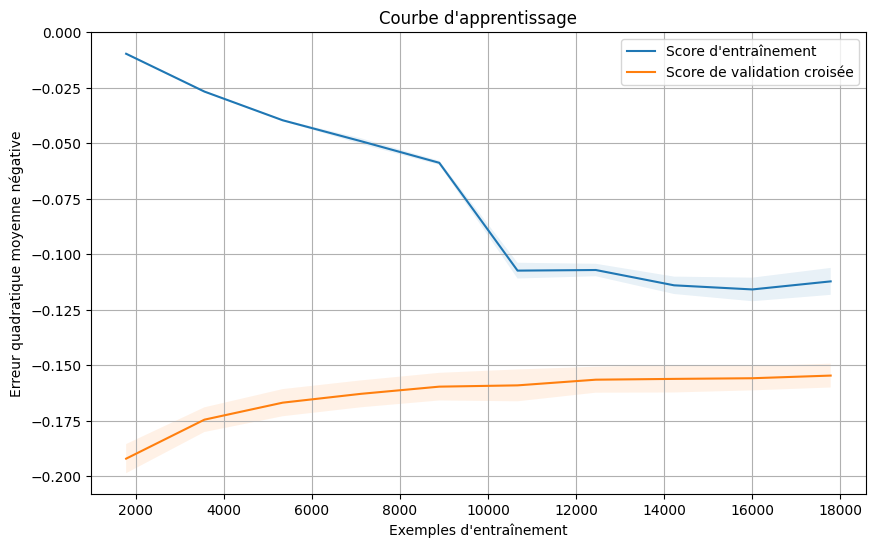

In [ ]:
# Générer les courbes d'apprentissage
train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_gbr,
    X=X_feature,
    y=y_label,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Score d\'entraînement')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, test_mean, label='Score de validation croisée')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel('Exemples d\'entraînement')
plt.ylabel('Erreur quadratique moyenne négative')
plt.title('Courbe d\'apprentissage')
plt.legend(loc='best')
plt.grid(True)
plt.show()

## Partie 4 : *Test du modèle*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/airbnb_test.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
test_pretraite = pretraitement(test.copy())
test_pretraite.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51877 entries, 0 to 51876
Data columns (total 72 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   id                                 51877 non-null  int64   
 1   property_type                      51877 non-null  category
 2   amenities                          51877 non-null  object  
 3   accommodates                       51877 non-null  int64   
 4   bathrooms                          51877 non-null  float64 
 5   cancellation_policy                51877 non-null  category
 6   cleaning_fee                       51877 non-null  int8    
 7   city                               51877 non-null  category
 8   description                        51877 non-null  object  
 9   host_has_profile_pic               51877 non-null  int8    
 10  host_identity_verified             51877 non-null  int8    
 11  host_response_rate                 51877 

In [ ]:
# Récupérer les mêmes features que pendant le training
training_features = X_train.columns.tolist()

# Sélectionner uniquement les features du test
X_test_final = test_pretraite[training_features]

predictions = best_gbr.predict(X_test_final)

In [ ]:
prediction = pd.DataFrame({'id': test['id'], 'log_price': predictions})
prediction.head()
prediction.to_csv('prediction.csv', index=False)
prediction.head(10)

,id,log_price
0,14282777,4.818359
1,17029381,5.307613
2,7824740,4.722635
3,19811650,5.937195
4,12410741,4.589559
5,19589738,4.369733
6,15470255,4.851098
7,6128434,4.772453
8,18358465,4.331310
9,8760362,3.741622


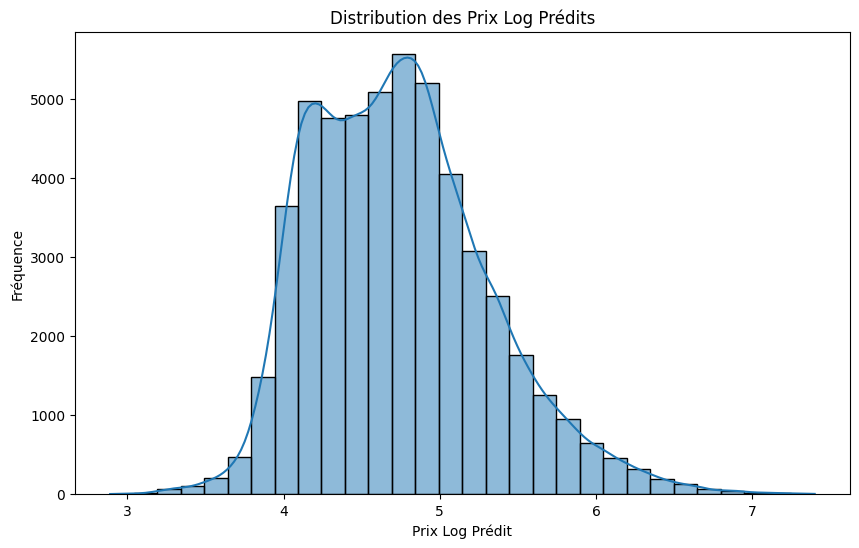

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(predictions, bins=30, kde=True)
plt.title('Distribution des Prix Log Prédits')
plt.xlabel('Prix Log Prédit')
plt.ylabel('Quantité')
plt.show()

Ce qui correspond à la forme du log_price originel!